# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

En este proyecto se va a relalizar un análisis de una muestra de datos para dos tipos de planes diferentes de la empresa Megaline. El propósito de este análisis es identificar que plan proporciona mayor cantidad de ingresos para la empresa. Para esto primero se va a realizar un limpieza de datos para contar con los datos correctos paa todo el análisis. Porteriormente se crearán tablas agreguapas donde de junten los datos necesarios para poder trabajar y objeter estadísticas necesarias. A partir de estas tablas se hará un análisis estadístico con gráficos para identificar la distribución de los datos y un resumen estadístico de la media, varianza y desviacióne estandar como otra perspectiva para comprender el comportamiento de los usuarios. Finalmente se realizará una prueba de hipótesis donde se responderá a la pregunta sobre si las tarifas por plan son iguales o no y si las tarifas para la ciudad de NY-NJ difiere del resto de ciudades. 

In [1]:
# Cargar todas las librerías que puedan ser necesarias 
import pandas as pd
import numpy as np 
from scipy import stats as st 
import math as mt
from math import factorial 
import seaborn as sns 
from matplotlib import pyplot as plt


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
tarifas = pd.read_csv ('/datasets/megaline_plans.csv')
usuarios = pd.read_csv ('/datasets/megaline_users.csv')
llamadas = pd.read_csv ('/datasets/megaline_calls.csv')
mensajes = pd.read_csv ('/datasets/megaline_messages.csv')
internet = pd.read_csv ('/datasets/megaline_internet.csv')


## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
tarifas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
tarifas.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se puede ver que no se presentan datos nulos en ninguna columna. Los tipos de datos para cada una son corrctos por lo que no se necsita modificación. Respecto a cambios, se puede trasnformar la columna mb pero month included a gb ya que esa es la unidad de medición con la que se va a trabajar para el análisis. 

## Corregir datos

In [5]:
#tranformar a gb incluidas los mb incluidos al mes. 
tarifas ['gb_included'] = tarifas ['mb_per_month_included']/1024
tarifas.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


In [6]:
 #eliminar la columna de mb que ya no sirve para futuros calculos
tarifas.drop(columns = ['mb_per_month_included'], inplace = True)
tarifas.head()

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_included
0,50,500,20,10,0.03,0.03,surf,15.0
1,1000,3000,70,7,0.01,0.01,ultimate,30.0


## Enriquecer los datos

In [7]:
#cambiar el nombre plan_name a name para poder cruzar con las otras tablas
tarifas.rename(columns = {'plan_name': 'plan'}, inplace = True) 
tarifas.head()

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_included
0,50,500,20,10,0.03,0.03,surf,15.0
1,1000,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
usuarios.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
usuarios.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Se puede ver que se tienen datos NaN en la columna churn date, sin embargo, se puede decir que está bien ya que representa que el cliente no ha dado de baja el servicio. Respecto al tipo de datos, para la columna reg date y churn date es necesario transformar a formato datetime para poder extraer el mes sin problemas posteriormente ya que todo el análisis se hará respecto a los meses. 

### Corregir los datos

In [10]:
#trasformar las columnas de que muestran fechas de formato object a formato datetime para poder trabajarlas correctamente. 
usuarios ['reg_date'] = pd.to_datetime (usuarios ['reg_date'], format = '%Y-%m-%d')
usuarios ['churn_date'] = pd.to_datetime (usuarios ['churn_date'], format = '%Y-%m-%d')

In [11]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [12]:
#se obtiene la distribución de la columna age principalmente para conocer el rango de edades con las que se está trabajando
usuarios.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


### Enriquecer los datos

No se requiere agregar nuevas columnas ni modificar el dataset, ya que es información general de los usuarios. 

## Llamadas

In [13]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
llamadas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para las llamadas
llamadas.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


No se presentan datos nulos. Respecto al tipo de datos, se debe tranformar a formato datetime la columna call date para manejarlos correctamente. La columna duration debe ser redondeada para arriba y transformada a enntero. 

### Corregir los datos

In [15]:
#transformar call date a formato datetime 
llamadas['call_date'] = pd.to_datetime (llamadas ['call_date'], format = '%Y-%m-%d')

In [16]:
llamadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [17]:
#redondear las duración de las llamadas hacia arriba 
llamadas['duration_round'] = llamadas['duration'].apply (np.ceil)
llamadas ['duration_round'] = llamadas ['duration_round'].astype ('int')

In [18]:
llamadas.head()

,id,user_id,call_date,duration,duration_round
0,1000_93,1000,2018-12-27,8.52,9
1,1000_145,1000,2018-12-27,13.66,14
2,1000_247,1000,2018-12-27,14.48,15
3,1000_309,1000,2018-12-28,5.76,6
4,1000_380,1000,2018-12-30,4.22,5


### Enriquecer los datos

In [19]:
#extraer el mes de la fecha de llamada
llamadas ['month'] = llamadas ['call_date'].dt.month

In [20]:
llamadas.head()

,id,user_id,call_date,duration,duration_round,month
0,1000_93,1000,2018-12-27,8.52,9,12
1,1000_145,1000,2018-12-27,13.66,14,12
2,1000_247,1000,2018-12-27,14.48,15,12
3,1000_309,1000,2018-12-28,5.76,6,12
4,1000_380,1000,2018-12-30,4.22,5,12


In [21]:
#se obtiene la distibución de los datos cuantitativos para tener una idea de con que se está trabajando
llamadas.describe()

,user_id,duration,duration_round,month
count,137735.000000,137735.000000,137735.000000,137735.000000
mean,1247.658046,6.745927,7.146673,9.320797
std,139.416268,5.839241,5.953919,2.412550
min,1000.000000,0.000000,0.000000,1.000000
25%,1128.000000,1.290000,2.000000,8.000000
50%,1247.000000,5.980000,6.000000,10.000000
75%,1365.000000,10.690000,11.000000,11.000000
max,1499.000000,37.600000,38.000000,12.000000


Se puede ver que el mínimo de duración de llamadas es de 0, lo quiere decir que no se realizaron llamadas, y el máximo de 38 min. Y se verifica que los meses estén correctos.

## Mensajes

In [22]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
mensajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [23]:
# Imprime una muestra de datos para los mensajes
mensajes.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


No se tienen datos nulos. Se debe transformar a formato datetime la columna message date en caso de requerir trabajar con la misma y extraer el mes. 

### Corregir los datos

In [24]:
#transformar fecha de mensaje a formato datetime 
mensajes['message_date'] = pd.to_datetime (mensajes['message_date'], format = '%Y-%m-%d')

In [25]:
mensajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

In [26]:
#Extraer el mes de la fecha mensaje y crear nueva columna
mensajes ['month'] = mensajes ['message_date'].dt.month

In [27]:
mensajes.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [28]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [29]:
# Imprime una muestra de datos para el tráfico de internet
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


No se tienen datos nulos. Se debe cambiar a formato datetime la columna session date. 

### Corregir los datos

In [30]:
#transformar la columna session_date a formato datetime 
internet ['session_date'] = pd.to_datetime (internet ['session_date'], format = '%Y-%m-%d')

In [31]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

In [32]:
#extraer el mes de la fecha de uso de sesion en caso de que se necesite trabajar con el mismo 
internet ['month'] = internet ['session_date'].dt.month

In [33]:
internet.head()

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


## Estudiar las condiciones de las tarifas

In [34]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
tarifas

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_included
0,50,500,20,10,0.03,0.03,surf,15.0
1,1000,3000,70,7,0.01,0.01,ultimate,30.0


## Agregar datos por usuario

Se van a crear tablas dinámicas para cada apartado, lo cual nos permitirá crer una nueva tabla solo con la información a usar posteriormente para el análisis.

In [35]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado. Se crea una tabla pivote para visualizar el resultado 
llamadas_total = llamadas.pivot_table (index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
llamadas_total.columns = ['total_llamadas']
llamadas_total.head()

total_llamadas
user_id month                
1000    12                 16
1001    8                  27
        9                  49
        10                 65
        11                 64

In [36]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado. Se muestra el mismo en una tabla dinámica
llamadas_resumen = llamadas.pivot_table (index = ['user_id', 'month'], values = 'duration_round', aggfunc = 'sum')
llamadas_resumen.columns = ['min_usados']
llamadas_resumen.head()

min_usados
user_id month            
1000    12            124
1001    8             182
        9             315
        10            393
        11            426

In [37]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
mensajes_total = mensajes.pivot_table (index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
mensajes_total.columns = ['total_mensajes']
mensajes_total.head()

total_mensajes
user_id month                
1000    12                 11
1001    8                  30
        9                  44
        10                 53
        11                 36

In [38]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_total = internet.pivot_table (index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
internet_total.head()

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30

In [39]:
# transformar a gb el total del internet usado al mes por usuario ya que es la medida con la que se va a trabajar
internet_total ['gb_used'] = internet_total ['mb_used']/1024
internet_total.head()

mb_used    gb_used
user_id month                     
1000    12      1901.47   1.856904
1001    8       6919.15   6.756982
        9      13314.82  13.002754
        10     22330.49  21.807119
        11     18504.30  18.070605

In [40]:
#se redondea las gb usadas hacia arriba y se pasa a formato int
internet_total ['gb_used_rounded'] = internet_total ['gb_used'].apply(np.ceil).astype(int)
internet_total.head()

mb_used    gb_used  gb_used_rounded
user_id month                                      
1000    12      1901.47   1.856904                2
1001    8       6919.15   6.756982                7
        9      13314.82  13.002754               14
        10     22330.49  21.807119               22
        11     18504.30  18.070605               19

In [41]:
#se eliminan las columnas que ya no me sirven para evitar la acumulación de datos innecesarios
internet_total.drop (columns = ['mb_used', 'gb_used'], inplace = True)
internet_total.head()

gb_used_rounded
user_id month                 
1000    12                   2
1001    8                    7
        9                   14
        10                  22
        11                  19

In [42]:
#renombrar la columna con un nombre más facil de usar
internet_total.columns = ['gb_usados']
internet_total.head()

gb_usados
user_id month           
1000    12             2
1001    8              7
        9             14
        10            22
        11            19

In [43]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month para contar con todos los datos en una misma tabla a usar posteriormente
#se une con el método merge en una sola línea todas las tablas en lugar de hacer varios códigos para lo mismo
resumen_uso = llamadas_total.merge (llamadas_resumen, 
                                    on = ['user_id', 'month'], 
                                    how = 'outer'
                                   ).merge(mensajes_total, 
                                    on = ['user_id', 'month'], 
                                    how = 'outer'
                                    ). merge (internet_total,
                                    on = ['user_id', 'month'], 
                                    how = 'outer')
resumen_uso.head()

total_llamadas  min_usados  total_mensajes  gb_usados
user_id month                                                       
1000    12               16.0       124.0            11.0        2.0
1001    8                27.0       182.0            30.0        7.0
        9                49.0       315.0            44.0       14.0
        10               65.0       393.0            53.0       22.0
        11               64.0       426.0            36.0       19.0

In [44]:
# Añade la información de la tarifa. Se agrega las columnas de user_id y plan de la tabla usuarios para poder unir con las tarifas mediante el plan
consolidado = resumen_uso.merge(usuarios[['user_id', 'plan',]], 
                                on = 'user_id', 
                                how = 'left' 
                               ).merge(tarifas, 
                                on = 'plan', 
                                how = 'left'
                                ).set_index(resumen_uso.index)
consolidado.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  messages_included  minutes_included  usd_monthly_pay  \
user_id month                                                                   
1000    12     ultimate               1000              3000               70   
1001    8          surf                 50               500               20   
        9          surf                 50               500               20   
        10         surf                 50               500               20   
        11         surf                 50               500               20   

               usd_per_gb  usd_per_message  usd_per_minute  gb_included  
user_id month                                                            
1000    12              7             0.01            0.01         30.0  
1001    8              10             0.03            0.03         15.0  
        9              10             0.03            0.03         15.0  
        10             10             0.03            0.03         15.0  
        11             10             0.03            0.03         15.0

In [45]:
#se verifica a información general del nuevo dataframe 
consolidado.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1311, 6)
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            2293 non-null   int64  
 1   total_llamadas     2258 non-null   float64
 2   min_usados         2258 non-null   float64
 3   total_mensajes     1806 non-null   float64
 4   gb_usados          2277 non-null   float64
 5   plan               2293 non-null   object 
 6   messages_included  2293 non-null   int64  
 7   minutes_included   2293 non-null   int64  
 8   usd_monthly_pay    2293 non-null   int64  
 9   usd_per_gb         2293 non-null   int64  
 10  usd_per_message    2293 non-null   float64
 11  usd_per_minute     2293 non-null   float64
 12  gb_included        2293 non-null   float64
dtypes: float64(7), int64(5), object(1)
memory usage: 260.1+ KB


Se puede ver que se tienen datos nulos, sin embargo se los puede rellenar con 0 ya que significa que ese usuario no hizo uso de ese funcionalidad. 

In [46]:
#se completa los datos nulos con 0, en este caso corresponde 0 ya qe significa que ese usuario no utilizo ese servicio
resumen_final = consolidado.copy()
resumen_final ['total_llamadas'] = resumen_final ['total_llamadas'] .fillna (0)
resumen_final ['min_usados'] = resumen_final ['min_usados'] .fillna (0)
resumen_final ['total_mensajes'] = resumen_final ['total_mensajes'] .fillna (0)
resumen_final ['gb_usados'] = resumen_final ['gb_usados'] .fillna (0)
resumen_final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1311, 6)
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            2293 non-null   int64  
 1   total_llamadas     2293 non-null   float64
 2   min_usados         2293 non-null   float64
 3   total_mensajes     2293 non-null   float64
 4   gb_usados          2293 non-null   float64
 5   plan               2293 non-null   object 
 6   messages_included  2293 non-null   int64  
 7   minutes_included   2293 non-null   int64  
 8   usd_monthly_pay    2293 non-null   int64  
 9   usd_per_gb         2293 non-null   int64  
 10  usd_per_message    2293 non-null   float64
 11  usd_per_minute     2293 non-null   float64
 12  gb_included        2293 non-null   float64
dtypes: float64(7), int64(5), object(1)
memory usage: 260.1+ KB


In [47]:
# Calcula el ingreso mensual para cada usuario. Primero se calcula los excesos para cada uno
#se crea una funcion que calcule los excesos y en la tabla no nos encontremos con valores negativos. De ser el caso que el usuario usó menos de lo que tenía incluido. 
def excesos (x):
    if x > 0:
        return x
    else: 
        return 0

In [48]:
#calcular minutos de llamadas en exceso por usuario. Se crea nueva columna. Se resta lo usado de lo incluido y se aplica la función
resumen_final ['min_exceso'] = resumen_final ['min_usados'] - resumen_final['minutes_included']
resumen_final ['min_exceso'] = resumen_final ['min_exceso'].apply (excesos)
resumen_final.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  messages_included  minutes_included  usd_monthly_pay  \
user_id month                                                                   
1000    12     ultimate               1000              3000               70   
1001    8          surf                 50               500               20   
        9          surf                 50               500               20   
        10         surf                 50               500               20   
        11         surf                 50               500               20   

               usd_per_gb  usd_per_message  usd_per_minute  gb_included  \
user_id month                                                             
1000    12              7             0.01            0.01         30.0   
1001    8              10             0.03            0.03         15.0   
        9              10             0.03            0.03         15.0   
        10             10             0.03            0.03         15.0   
        11             10             0.03            0.03         15.0   

               min_exceso  
user_id month              
1000    12            0.0  
1001    8             0.0  
        9             0.0  
        10            0.0  
        11            0.0

In [49]:
#calcular mensajes en exceso por usuario.  Se crea nueva columna. Se resta lo usado de lo incluido y se aplica la función. 
resumen_final ['msj_exceso'] = resumen_final ['total_mensajes'] - resumen_final['messages_included']
resumen_final ['msj_exceso'] = resumen_final ['msj_exceso'].apply (excesos)
resumen_final.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  messages_included  minutes_included  usd_monthly_pay  \
user_id month                                                                   
1000    12     ultimate               1000              3000               70   
1001    8          surf                 50               500               20   
        9          surf                 50               500               20   
        10         surf                 50               500               20   
        11         surf                 50               500               20   

               usd_per_gb  usd_per_message  usd_per_minute  gb_included  \
user_id month                                                             
1000    12              7             0.01            0.01         30.0   
1001    8              10             0.03            0.03         15.0   
        9              10             0.03            0.03         15.0   
        10             10             0.03            0.03         15.0   
        11             10             0.03            0.03         15.0   

               min_exceso  msj_exceso  
user_id month                          
1000    12            0.0         0.0  
1001    8             0.0         0.0  
        9             0.0         0.0  
        10            0.0         3.0  
        11            0.0         0.0

In [50]:
#calcular las gb en exceso por usuario. Se crea nueva columna. Se resta lo usado de lo incluido y se aplica la función. 
resumen_final ['gb_exceso'] = resumen_final ['gb_usados'] - resumen_final['gb_included']
resumen_final ['gb_exceso'] = resumen_final ['gb_exceso'].apply (excesos)
resumen_final.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  messages_included  minutes_included  usd_monthly_pay  \
user_id month                                                                   
1000    12     ultimate               1000              3000               70   
1001    8          surf                 50               500               20   
        9          surf                 50               500               20   
        10         surf                 50               500               20   
        11         surf                 50               500               20   

               usd_per_gb  usd_per_message  usd_per_minute  gb_included  \
user_id month                                                             
1000    12              7             0.01            0.01         30.0   
1001    8              10             0.03            0.03         15.0   
        9              10             0.03            0.03         15.0   
        10             10             0.03            0.03         15.0   
        11             10             0.03            0.03         15.0   

               min_exceso  msj_exceso  gb_exceso  
user_id month                                     
1000    12            0.0         0.0        0.0  
1001    8             0.0         0.0        0.0  
        9             0.0         0.0        0.0  
        10            0.0         3.0        7.0  
        11            0.0         0.0        4.0

In [51]:
#eliminar columnas que ya no se van a usar para tener mejor visualización de todos los datos necesarios. 
resumen_final.drop(columns = ['messages_included', 'minutes_included', 'gb_included'], inplace = True)
resumen_final.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                           
1000    12     ultimate               70           7             0.01   
1001    8          surf               20          10             0.03   
        9          surf               20          10             0.03   
        10         surf               20          10             0.03   
        11         surf               20          10             0.03   

               usd_per_minute  min_exceso  msj_exceso  gb_exceso  
user_id month                                                     
1000    12               0.01         0.0         0.0        0.0  
1001    8                0.03         0.0         0.0        0.0  
        9                0.03         0.0         0.0        0.0  
        10               0.03         0.0         3.0        7.0  
        11               0.03         0.0         0.0        4.0

In [52]:
#Se crea una nueva columna donde se calcula la tarifa final papaga mensualmente por cada usuario. se caclcula el precio adicional multiplicando el exceso por el precio extra de ese servicio y sumando todos,
# y  para la tarifa final se suma la base original que ya se paga mas lo adicional. 
resumen_final ['usd_adicional'] = (resumen_final ['min_exceso'] * resumen_final ['usd_per_minute']) + (resumen_final['msj_exceso'] * resumen_final['usd_per_message']) + (resumen_final['gb_exceso'] * resumen_final ['usd_per_gb'])
resumen_final ['tarifa_final'] = resumen_final ['usd_monthly_pay'] + resumen_final ['usd_adicional']
resumen_final.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  usd_monthly_pay  usd_per_gb  usd_per_message  \
user_id month                                                           
1000    12     ultimate               70           7             0.01   
1001    8          surf               20          10             0.03   
        9          surf               20          10             0.03   
        10         surf               20          10             0.03   
        11         surf               20          10             0.03   

               usd_per_minute  min_exceso  msj_exceso  gb_exceso  \
user_id month                                                      
1000    12               0.01         0.0         0.0        0.0   
1001    8                0.03         0.0         0.0        0.0   
        9                0.03         0.0         0.0        0.0   
        10               0.03         0.0         3.0        7.0   
        11               0.03         0.0         0.0        4.0   

               usd_adicional  tarifa_final  
user_id month                               
1000    12              0.00         70.00  
1001    8               0.00         20.00  
        9               0.00         20.00  
        10             70.09         90.09  
        11             40.00         60.00

In [53]:
#eliminar columnas que ya no se van a utilizar para mejorar la visualización de los datos necesarios. 
resumen_final.drop (columns = ['usd_monthly_pay', 'usd_per_gb', 'usd_per_message',
       'usd_per_minute'], inplace = True)
resumen_final.head(10)

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   
        12        1001            56.0       412.0            44.0       19.0   
1002    10        1002            11.0        59.0            15.0        7.0   
        11        1002            55.0       386.0            32.0       19.0   
        12        1002            47.0       384.0            41.0       15.0   
1003    12        1003           149.0      1104.0            50.0       27.0   

                   plan  min_exceso  msj_exceso  gb_exceso  usd_adicional  \
user_id month                                                               
1000    12     ultimate         0.0         0.0        0.0           0.00   
1001    8          surf         0.0         0.0        0.0           0.00   
        9          surf         0.0         0.0        0.0           0.00   
        10         surf         0.0         3.0        7.0          70.09   
        11         surf         0.0         0.0        4.0          40.00   
        12         surf         0.0         0.0        4.0          40.00   
1002    10         surf         0.0         0.0        0.0           0.00   
        11         surf         0.0         0.0        4.0          40.00   
        12         surf         0.0         0.0        0.0           0.00   
1003    12         surf       604.0         0.0       12.0         138.12   

               tarifa_final  
user_id month                
1000    12            70.00  
1001    8             20.00  
        9             20.00  
        10            90.09  
        11            60.00  
        12            60.00  
1002    10            20.00  
        11            60.00  
        12            20.00  
1003    12           158.12

In [54]:
#se obtiene un resumen general de todos los datos para conocer generalmente cada variable y su comportamiento. 
resumen_final.describe()

,user_id,total_llamadas,min_usados,total_mensajes,gb_usados,min_exceso,msj_exceso,gb_exceso,usd_adicional,tarifa_final
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,1246.075883,60.067597,429.283471,33.166594,16.870475,42.160925,4.810728,2.755342,28.651191,64.351147
std,143.051927,32.402563,236.320077,34.070085,7.796174,107.799717,16.450516,4.884966,49.623494,46.624945
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1122.000000,38.000000,265.000000,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,23.480000
50%,1245.000000,60.000000,425.000000,26.000000,17.000000,0.000000,0.000000,0.000000,0.420000,70.000000
75%,1368.000000,79.000000,572.000000,51.000000,21.000000,0.000000,0.000000,4.000000,41.200000,70.000000
max,1499.000000,205.000000,1510.000000,266.000000,70.000000,1010.000000,216.000000,55.000000,570.370000,590.370000


## Estudia el comportamiento de usuario

Se realizarán histogramas principlamente para conocer a distribución de los datos y ver las diferencias entre los distintos planes. También se obtendrá la media, varianza y desviación estandar de cada variable a trabajar para tener estadíssticas descriptvas que nos digan como se comportan los usuarios. 

### Llamadas

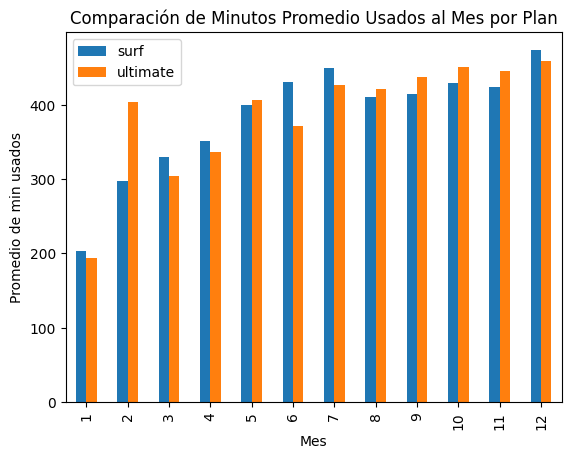

In [55]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
promedio=resumen_final.pivot_table (index = 'month', columns = 'plan', values = ['min_usados'], aggfunc = 'mean')
promedio.plot (kind = 'bar', xlabel = 'Mes', ylabel = 'Promedio de min usados', 
               title = 'Comparación de Minutos Promedio Usados al Mes por Plan')
plt.legend (['surf', 'ultimate'])
plt.show()

En el gráfico de barras anterior, se compara el promedio mensual de la duración de llamadas por minutos para el plan Surf y Ultimate. Se puede ver que en durante 6 meses al año se utilizan más minutos en el plan surf, y para los otros 6 meses los usuarios del plan ultimate utilizan más minutos al mes. Sin emabargo, la utilización entre ambos planes es similar. El único mes es febrero donde se ve una  gran diferencia, donde lso usuarios del plan ultimate utilzan más minutos.   
Para el plan ultimate la utilización va aumentando conforme pasan los meses, donde diciembre es el mes que más utilizan. 
Para el plan surf llega a lo más alto en julio, de ahí baja relativamente un poco y en diciembre es el mes que más utilización tiene al igual que en el otro plan.

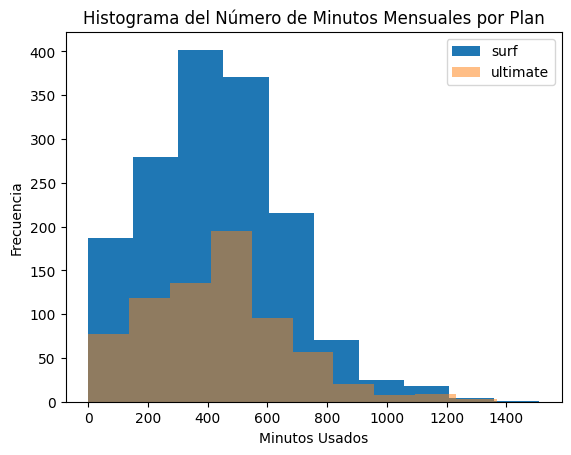

In [56]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
resumen_final[resumen_final['plan'] == 'surf']['min_usados'].plot (kind = 'hist', bins = 10)
resumen_final[resumen_final['plan'] == 'ultimate']['min_usados'].plot (kind = 'hist', bins = 10, alpha = 0.5)
plt.title('Histograma del Número de Minutos Mensuales por Plan')
plt.xlabel('Minutos Usados')
plt.ylabel('Frecuencia')
plt.legend (['surf', 'ultimate'])
plt.show()


En el anterior histograma se puede ver una comparación en la distribución de los minutos usados por la cantidad de usuarios. Podemos observar que hay una mayor cantidad de personas que toman en plan surf. Sin embargo, para los 2 planes la mayor cantidad de personas utilizan entre 400 y 600 min al mes. Con este gráfico podemos ver que varios usuarios del plan surf utilizan bastante más de la cantidad total mensual de minutos incluidos que era 500, siendo 1400 la mayor cantidad de min usados.Mientras que para el plan ultimate no se presentan excesos en cuanto a los minutos usados respecto a lo incluido. 

In [57]:
# Calcula la media ,la varianza y la distribucion estandar de la duración mensual de llamadas.
est_tarifas= resumen_final.groupby('plan')['min_usados'].agg(['mean', 'var', 'std']).reset_index()
est_tarifas.rename(columns={'mean': 'media', 'var': 'varianza', 'std': 'desviacion_estandar'}, inplace=True)
print(est_tarifas)

       plan       media      varianza  desviacion_estandar
0      surf  428.749523  54968.279461           234.453150
1  ultimate  430.450000  57844.464812           240.508762


Respecto a la media, varianza y desviación estandar para los minutos usados por plan. se puede ver que existe una diferencia entre estos planes. La varianza del plan ultimate es más grande que para el plan surf, lo que quiere decir que sus datos están más dispersos de la media de datos. A pesar de que no es una diferenza tan grande entre los resultados, de igualmente se dice que los usuarios se comportan distinto. 

Text(0.5, 1.0, 'Distribución de la Duración Mensual de Llamadas por Plan')

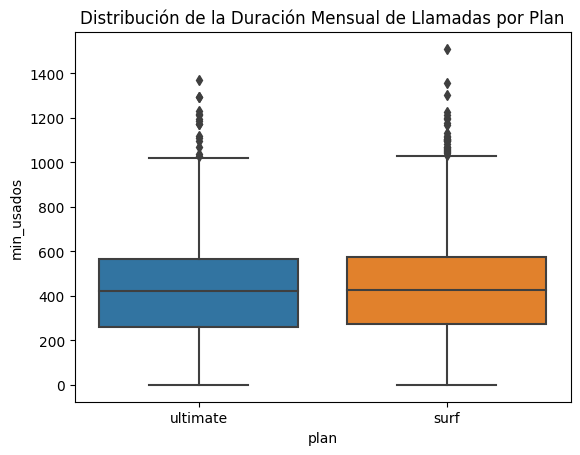

In [58]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot (x = 'plan', y = 'min_usados', data = resumen_final)
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')

Se puede ver en le diagrama de caja que el comportamiento de los usuarios respecto a ambos planes es relativamente similar, mas no se puede decir que son iguales. A pesar de que el plan ultimate incluye muchos más minutos, tienen a usar una cantidad similar a los del plan surf. En ambos plaenes hay casos atípicos, pero se puede ver que un usuario del plan surf está muy por encima del 75% de los datos. La mediana en ambos casos es muy cercana entre si. 

### Mensajes

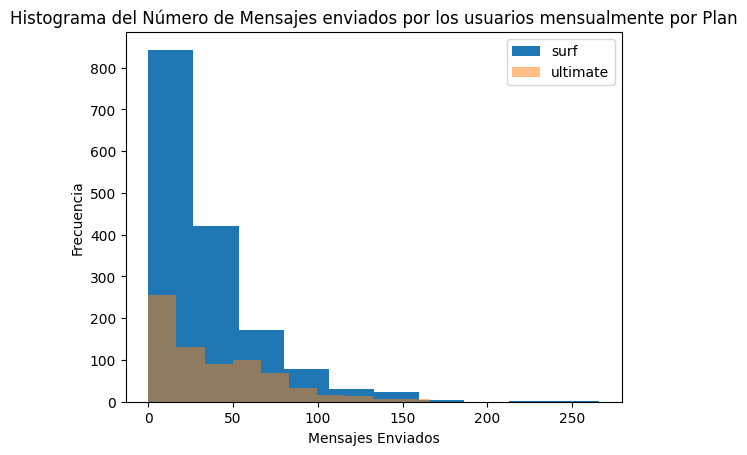

In [59]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan. Se crea un histogrma
resumen_final[resumen_final['plan'] == 'surf']['total_mensajes'].plot (kind = 'hist', bins = 10)
resumen_final[resumen_final['plan'] == 'ultimate']['total_mensajes'].plot (kind = 'hist', bins = 10, alpha = 0.5)
plt.title('Histograma del Número de Mensajes enviados por los usuarios mensualmente por Plan')
plt.xlabel('Mensajes Enviados')
plt.ylabel('Frecuencia')
plt.legend (['surf', 'ultimate'])
plt.show()

El histograma "Número de Mensajes enviados por los usuarios mensualmente por Plan" nos da una perspectiva clara del comportamiento de los usuarios respecto a cuantos mensajes envian al mes. Como se puede ver, existe una mayor cantidad de personas que utilizan el plan Surf, sin embargo las distribuciones de ambos planes son relativamente similares, donde la mayor frecuencia en ambos se presenta entre o a 15-20 mensajes al mes. Esto tiene mucho sentido , ya que hoy en día el servicio de mensajería instantánea a sido reemplazada por los mensajes que se evían utilizando internet como por whatsapp.
Sin embargo, para el plan surf hay usuarios que han utilizado hasta más de 250 mensajes al mes, esto se podría analizar más a profundidad dependiendo del tipo de trabajo que tenga esta persona, o la edad de la misma. 

In [60]:
# Calcula la media, la varianza y la desviacion estandar del numero de mensajes al mes que tienden a enviar por plan
est_tarifas= resumen_final.groupby('plan')['total_mensajes'].agg(['mean', 'var', 'std']).reset_index()
est_tarifas.rename(columns={'mean': 'media', 'var': 'varianza', 'std': 'desviacion_estandar'}, inplace=True)
print(est_tarifas)

       plan      media     varianza  desviacion_estandar
0      surf  31.159568  1126.724522            33.566717
1  ultimate  37.551389  1208.756744            34.767179


Estas estadísticas descriptivas, nos dicen que los usuarios de los diferentes planes si se comportan diferente. Para el plan ultimate, los datos se encuentran más dispersos a la media, esto se puede decir debido a que su varianza es más alta. 

Text(0.5, 1.0, 'Distribución de la Duración Mensual de Llamadas por Plan')

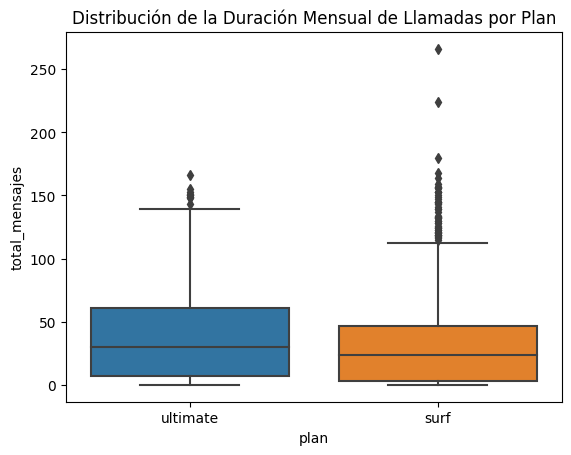

In [61]:
# Traza un diagrama de caja para visualizar la distribución del numero de mensajes al mes que tienden a enviar por plan
sns.boxplot (x = 'plan', y = 'total_mensajes', data = resumen_final)
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')

Este diagrama nos permite concluir que el 75% de los datos del plan surf están por debajo del plan ultimate. Sin embargo, existe una alta cantidad de datos atípicos en el plan surf que nos dicen que estan fuera del rango. Esto nos podría decir que hay gente que todavía utiliza mucho los mensajes de texto, o que tal vez es necesario corroborar con la empresas que estos datos son correctos y no presentan un error de medición.  

### Internet

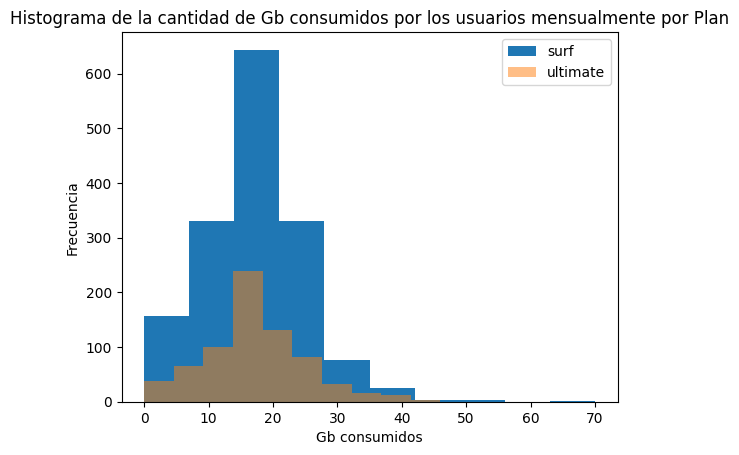

In [62]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan. se hace un histograma para ver la distribucion
resumen_final[resumen_final['plan'] == 'surf']['gb_usados'].plot (kind = 'hist', bins = 10)
resumen_final[resumen_final['plan'] == 'ultimate']['gb_usados'].plot (kind = 'hist', bins = 10, alpha = 0.5)
plt.title('Histograma de la cantidad de Gb consumidos por los usuarios mensualmente por Plan')
plt.xlabel('Gb consumidos')
plt.ylabel('Frecuencia')
plt.legend (['surf', 'ultimate'])
plt.show()

La distribución de la cantidad de GB consumidas por los usuarios de mbos planes se asemejan a una distribución normal. Se podría decir que el consumo de la mayoría de gente está entre las 15 a 25 gb, lo cual es una cantidad normal para la sociedad y las tendencias actuales. Al igual que en los anteriores análisis, muy pocos usuarios del plan surf llegan a consumir hasta 70 gb. Esto se podría analizar a que se dedica la persona como para consumir esa cantidad. 

In [63]:
# Calcula la media, la varianza y la desviacion estandar de la cantidad de gb consumidos al mes por plan
est_tarifas= resumen_final.groupby('plan')['gb_usados'].agg(['mean', 'var', 'std']).reset_index()
est_tarifas.rename(columns={'mean': 'media', 'var': 'varianza', 'std': 'desviacion_estandar'}, inplace=True)
print(est_tarifas)

       plan      media  varianza  desviacion_estandar
0      surf  16.670693  61.58360             7.847522
1  ultimate  17.306944  58.83055             7.670108


Estas medidas estadísticas son similares, sin embargo no se puede decir que iguales. Al tener una varianza diferente, se dice que el comportamiento de ambos grupos son diferentes, en donde los datos del plan surf estan más dispersos de la media como se pudo ver en el histograma. 

Text(0.5, 1.0, 'Distribución de la Duración Mensual de Llamadas por Plan')

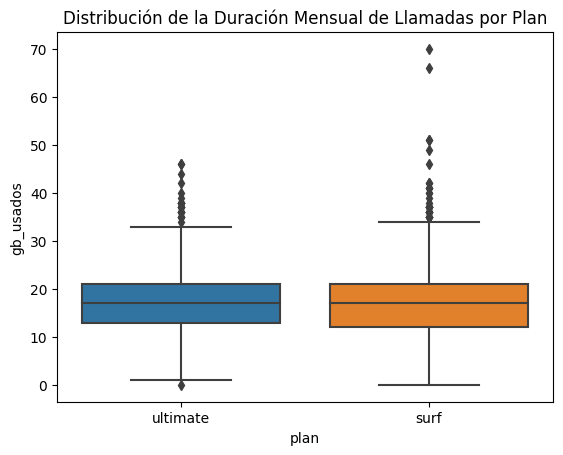

In [64]:
# Traza un diagrama de caja para visualizar la distribución del numero de gb consumidos por plan
sns.boxplot (x = 'plan', y = 'gb_usados', data = resumen_final)
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')

Al igual que en el análisis de media, varianza y des estándar, se puede ver mediante los diagamas de caja que los comportamientos de los usuarios son similares en cuando a la cantidad de gb consumidos al mes. Sin embargo se encuentran datos atípicos para ambos planes, especialmente para surf donde estos dátos están mas disperzados del 75% de los mismos. Cabe mencionar que sería importante analizarlos para conocer más sobre el comportamiento de estos usuarios. 

## Ingreso

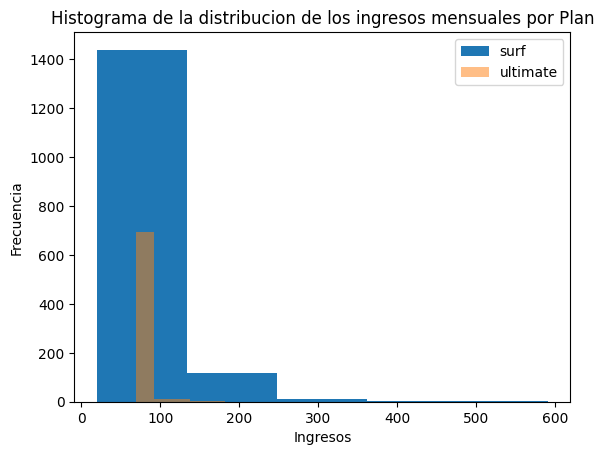

In [65]:
#se crea un histograma para ver la distribucion y el comportamiento respecto al ingreso por planes
resumen_final[resumen_final['plan'] == 'surf']['tarifa_final'].plot (kind = 'hist', bins = 5)
resumen_final[resumen_final['plan'] == 'ultimate']['tarifa_final'].plot (kind = 'hist', bins = 5, alpha = 0.5)
plt.title('Histograma de la distribucion de los ingresos mensuales por Plan')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.legend (['surf', 'ultimate'])
plt.show()

Al graficar los ingresos que se obtienen mensualmente para cada plan, se puede evidenciar notoriamente que el plan surf aporta con una mayor cantidad de ingresos mensuales. No solo porque existe una mayor cantidad de personas que haces uso de este plan, sinó porque al ser un plan básico, hay gente que termina el més pagando una alta cantidad por los excesos en los diferentes servicios. Se podría decir que la distribución en cuando a que la mayor cantidad de personas en ambos planes pagan al rededor de $90 al mes, superando en gran cantidad la base mensual del plan surf. Los usuarios del plan surf tienen a pagar más por excesos que los del plan últimate.  

In [66]:
#se calcula la media, varianza y desviacion estandar para analizar el comportamiento 
est_tarifas= resumen_final.groupby('plan')['tarifa_final'].agg(['mean', 'var', 'std']).reset_index()
est_tarifas.rename(columns={'mean': 'media', 'var': 'varianza', 'std': 'desviacion_estandar'}, inplace=True)
print(est_tarifas)

       plan      media     varianza  desviacion_estandar
0      surf  60.706408  3067.835152            55.388042
1  ultimate  72.313889   129.848486            11.395108


Este análisis nos muestra que en promedio la tarifa de ambos planes estan relativamente cerca, sin embargo la varianza tan alta del plan surf, nos dice que hay una gran cantidad de usuarios que pagan una cantidad bastante mayor a la media. 

Text(0.5, 1.0, 'Distribución de la tarifa mensual de usuarios por plan')

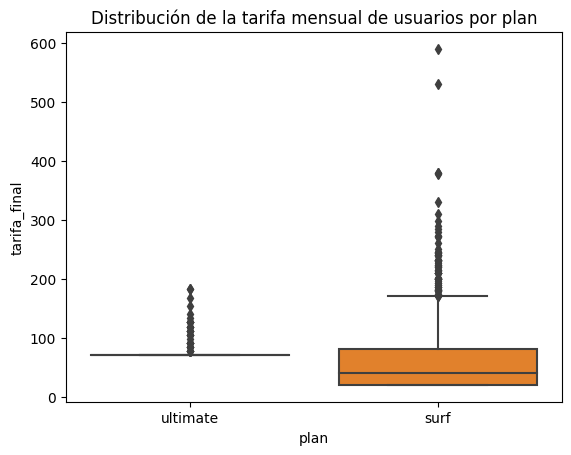

In [67]:
# Traza un diagrama de caja para visualizar la distribución del numero de gb consumidos por plan
sns.boxplot (x = 'plan', y = 'tarifa_final', data = resumen_final)
plt.title('Distribución de la tarifa mensual de usuarios por plan')

Se puede ver que el ingreso entre los planes es muy distino. Muy pocas personas escogen el plan ultimate a pesar de que tiene una base mayor, sin embargo los excesos que pagan extras son muy pocos debido a la cantidad que se incluye de cada servicio en el plan. En el plan surf, el 75% de las personas pagan algo similar a los del plan ultimate, pero hay muchos datos atípicos que superan altamente el rango de lo que pagan los usuarios, siendo estos datos atípicos lo que le genera mayor ingreso a la empresa.  

## Prueba las hipótesis estadísticas

H0: Los ingresos promedio de los usuarios para los planes Surf y Ultimate son iguales

Ha: Los ingresos promedio de los usuarios para los planes Surf y Ultimate difieren 

Se utiliza una prueba de dos colas ya que solo queremos saber si son diferentes, indiferentemente si una es mayor a otra.  Se usa una prueba st.ttest_ind ya que contamos con 2 muestras (surf y ultimate)

Se utiliza un valor de alpha 0.05, como umbral de significancia estadistica el cual es lo suficientemente representativo para poder aceptar o rechazar la hipotesis nula

In [68]:
# Prueba las hipótesis
alpha = 0.05 
results = st.ttest_ind (
    resumen_final[resumen_final['plan'] == 'surf'] ['tarifa_final'], 
    resumen_final[resumen_final['plan'] == 'ultimate'] ['tarifa_final'], 
    equal_var = False)

print ('valor p:', results.pvalue)

if results.pvalue < alpha:
    print ('Rechazamos la hipotesis nula')
else:
    print ('No podemos rechazar la hipotesis nula')

valor p: 3.1703905481135734e-15
Rechazamos la hipotesis nula


Después de realizar una prueba de hipótesis, donde la H0 era que los ingresos promedio de ambos planes son similares, se puede decir que se rechaza la hipótesis nula. Es decir que los ingresos entre planes son diferentes. Esto se corrobora con los análisis previos realizados. 

El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.

In [79]:
#elimino la columna user_id de mi tabla resumen final para poder unir la columna ciudad de mi tabla usuarios. Ya que al tener como index y columna se hace ambiguo para unir. 
resumen_f = resumen_final.drop(columns = ['user_id'])
resumen_f

total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                          
1000    12               16.0       124.0            11.0        2.0   
1001    8                27.0       182.0            30.0        7.0   
        9                49.0       315.0            44.0       14.0   
        10               65.0       393.0            53.0       22.0   
        11               64.0       426.0            36.0       19.0   
...                       ...         ...             ...        ...   
1349    12                0.0         0.0            61.0       13.0   
1361    5                 0.0         0.0             2.0        2.0   
1482    10                0.0         0.0             2.0        0.0   
1108    12                0.0         0.0             0.0        1.0   
1311    6                 0.0         0.0             0.0        2.0   

                   plan  min_exceso  msj_exceso  gb_exceso  usd_adicional  \
user_id month                                                               
1000    12     ultimate         0.0         0.0        0.0           0.00   
1001    8          surf         0.0         0.0        0.0           0.00   
        9          surf         0.0         0.0        0.0           0.00   
        10         surf         0.0         3.0        7.0          70.09   
        11         surf         0.0         0.0        4.0          40.00   
...                 ...         ...         ...        ...            ...   
1349    12         surf         0.0        11.0        0.0           0.33   
1361    5          surf         0.0         0.0        0.0           0.00   
1482    10     ultimate         0.0         0.0        0.0           0.00   
1108    12     ultimate         0.0         0.0        0.0           0.00   
1311    6      ultimate         0.0         0.0        0.0           0.00   

               tarifa_final  
user_id month                
1000    12            70.00  
1001    8             20.00  
        9             20.00  
        10            90.09  
        11            60.00  
...                     ...  
1349    12            20.33  
1361    5             20.00  
1482    10            70.00  
1108    12            70.00  
1311    6             70.00  

[2293 rows x 10 columns]

In [70]:
#uno el dataframe resumen_final con la informacion de ciudad por user_id del dataframe usuarios. 
resumen_ciudad = resumen_f.merge (usuarios[['city', 'user_id']], 
                                on = 'user_id', 
                                how = 'left').set_index(resumen_final.index)
resumen_ciudad.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  min_exceso  msj_exceso  gb_exceso  usd_adicional  \
user_id month                                                               
1000    12     ultimate         0.0         0.0        0.0           0.00   
1001    8          surf         0.0         0.0        0.0           0.00   
        9          surf         0.0         0.0        0.0           0.00   
        10         surf         0.0         3.0        7.0          70.09   
        11         surf         0.0         0.0        4.0          40.00   

               tarifa_final                                   city  
user_id month                                                       
1000    12            70.00  Atlanta-Sandy Springs-Roswell, GA MSA  
1001    8             20.00        Seattle-Tacoma-Bellevue, WA MSA  
        9             20.00        Seattle-Tacoma-Bellevue, WA MSA  
        10            90.09        Seattle-Tacoma-Bellevue, WA MSA  
        11            60.00        Seattle-Tacoma-Bellevue, WA MSA

In [71]:
#verifico que no tenga valores nulos 
resumen_ciudad.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2293 entries, (1000, 12) to (1311, 6)
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         2293 non-null   int64  
 1   total_llamadas  2293 non-null   float64
 2   min_usados      2293 non-null   float64
 3   total_mensajes  2293 non-null   float64
 4   gb_usados       2293 non-null   float64
 5   plan            2293 non-null   object 
 6   min_exceso      2293 non-null   float64
 7   msj_exceso      2293 non-null   float64
 8   gb_exceso       2293 non-null   float64
 9   usd_adicional   2293 non-null   float64
 10  tarifa_final    2293 non-null   float64
 11  city            2293 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 242.2+ KB


In [72]:
#Crear una nueva tabla con los datos que contienen solo la ciudad NY-NY
NY_NJ = resumen_ciudad[resumen_ciudad['city'].str.contains('NY-NJ')]
NY_NJ.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1014    11        1014            28.0       163.0             9.0        2.0   
        12        1014           150.0      1114.0            64.0        8.0   
1022    5         1022            39.0       302.0             0.0        5.0   
        6         1022            76.0       490.0             0.0       23.0   
        7         1022            70.0       475.0             0.0       10.0   

               plan  min_exceso  msj_exceso  gb_exceso  usd_adicional  \
user_id month                                                           
1014    11     surf         0.0         0.0        0.0           0.00   
        12     surf       614.0        14.0        0.0          18.84   
1022    5      surf         0.0         0.0        0.0           0.00   
        6      surf         0.0         0.0        8.0          80.00   
        7      surf         0.0         0.0        0.0           0.00   

               tarifa_final                                       city  
user_id month                                                           
1014    11            20.00  New York-Newark-Jersey City, NY-NJ-PA MSA  
        12            38.84  New York-Newark-Jersey City, NY-NJ-PA MSA  
1022    5             20.00  New York-Newark-Jersey City, NY-NJ-PA MSA  
        6            100.00  New York-Newark-Jersey City, NY-NJ-PA MSA  
        7             20.00  New York-Newark-Jersey City, NY-NJ-PA MSA

In [73]:
#calcular la media, var, y std para la tarifa final de los datos que tienen la ciudad NY-NJ
media_tarifa = NY_NJ['tarifa_final'].mean()
varianza_tarifa = NY_NJ['tarifa_final'].var()
desviacion_estandar_tarifa = NY_NJ['tarifa_final'].std()

In [74]:
print (media_tarifa)
print (varianza_tarifa )
print (desviacion_estandar_tarifa )

59.921352785145885
1895.5456899204246
43.537865013346995


In [75]:
#crear una tabla nueva con todos los datos que no contienen a la ciudad NY-NJ
Not_NY_NJ = resumen_ciudad.query('city not in @NY_NJ.city')
Not_NY_NJ.head()

user_id  total_llamadas  min_usados  total_mensajes  gb_usados  \
user_id month                                                                   
1000    12        1000            16.0       124.0            11.0        2.0   
1001    8         1001            27.0       182.0            30.0        7.0   
        9         1001            49.0       315.0            44.0       14.0   
        10        1001            65.0       393.0            53.0       22.0   
        11        1001            64.0       426.0            36.0       19.0   

                   plan  min_exceso  msj_exceso  gb_exceso  usd_adicional  \
user_id month                                                               
1000    12     ultimate         0.0         0.0        0.0           0.00   
1001    8          surf         0.0         0.0        0.0           0.00   
        9          surf         0.0         0.0        0.0           0.00   
        10         surf         0.0         3.0        7.0          70.09   
        11         surf         0.0         0.0        4.0          40.00   

               tarifa_final                                   city  
user_id month                                                       
1000    12            70.00  Atlanta-Sandy Springs-Roswell, GA MSA  
1001    8             20.00        Seattle-Tacoma-Bellevue, WA MSA  
        9             20.00        Seattle-Tacoma-Bellevue, WA MSA  
        10            90.09        Seattle-Tacoma-Bellevue, WA MSA  
        11            60.00        Seattle-Tacoma-Bellevue, WA MSA

In [76]:
#calculo la media, var, y std para la tarifa final de los datos que no tienen la ciudad NY-NJ
media_NotNY = Not_NY_NJ['tarifa_final'].mean()
varianza_NotNY = Not_NY_NJ['tarifa_final'].var()
desviacion_NotNY = Not_NY_NJ['tarifa_final'].std()

In [77]:
print (media_NotNY)
print (varianza_NotNY)
print (desviacion_NotNY)

65.2227713987474
2225.0479943518917
47.170414396652184


Puedo comprobar que las varianzar de ambas muestras son diferentes, lo que me permite establecer mi parámetro equal var  como False en mi prueba de hipótesis. 

H0: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.

Ha: El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Se selecciona una prueba de dos colas ya que solo quiero si es diferente, no ni es mayor o menor. Se realiza una prueba st.ttest.ind ya que contamos con 2 muestras (NY-NJ, todo lo demas).
Se selecciona un nivel de significancia de 0.05 para poder concluir si se acepta o rechaza la hipotesis nula, siendo lo suficientemente representativo.

In [78]:
# Prueba las hipótesis
alpha = 0.05 
result2 = st.ttest_ind(
          NY_NJ ['tarifa_final'],
        Not_NY_NJ['tarifa_final'],
        equal_var = False )

print ('valor p:', result2.pvalue)

if result2.pvalue < alpha:
    print ('Rechazamos la hipotesis nula')
else:
    print ('No podemos rechazar la hipotesis nula')

valor p: 0.0335256158853001
Rechazamos la hipotesis nula


Se rechaza la hipótesis nula, es decir los ingresos entre NY-NJ son diferentes a los ingresos del resto de ciudades donde se tienen clientes. Esto tiene sentido ya que para que los ingresos sean iguales, la mayor cantidad de usuarios deberían estan en NY-NJ. 

## Conclusión general

- Después de realizar un análisis exahustivo para la empresa Megaline para los planes surf y ultimate, se puede concluir que la mayor cantidad de usuarios utilizan en plan surf.
- A pesar de que surf tiene una base menor a ultimate, los ingresos que este plan representa son significativamente mayores a los ingresos del plan ultimate. 
- Los usuarios del plan surf tienden a pagar más por los excesos utilizados de los servicios ofrecidos dentro de este plan, siendo lo que mayor cantidad de ingresos le representa a la empresa. Los usuarios del plan ultimate casi no pagan exceso por la cantidad de minutos, msj y gb que se incluye en el plan. 
- Se debe promocionar más el plan surf para que una mayor cantidad de usuarios decidan hacer uso del mismo. 
- Se pudo evidenciar que los comportamientos de los usuarios eran distintos para cada plan, sin embargo sus distribuciones se comportaban de manera similar. 
- Los ingresos del área de NY-NJ son distintos a los ingresos del resto de áreas donde se ofrece el servicio. Esto hace sentido ya que solo es 1 área comparada con todas las demás. Para que sean iguales, la mayor cantidad de usuarios deberían estan ubicados el en área de NY-NJ.